In [1]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
from datasets import load_dataset
from anls_star import anls_score
import requests
import torch

In [2]:
ds = load_dataset("danjacobellis/docvqa",split='train')

Resolving data files:   0%|          | 0/57 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/57 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
model_id = "google/paligemma-3b-ft-docvqa-896"
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    revision="bfloat16",
)
processor = AutoProcessor.from_pretrained(model_id)

/home/dgj335/.local/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [10]:
ds[0]['question']

'what is the date mentioned in this letter?'

In [11]:
ds[0]['answer']

['1/8/93']

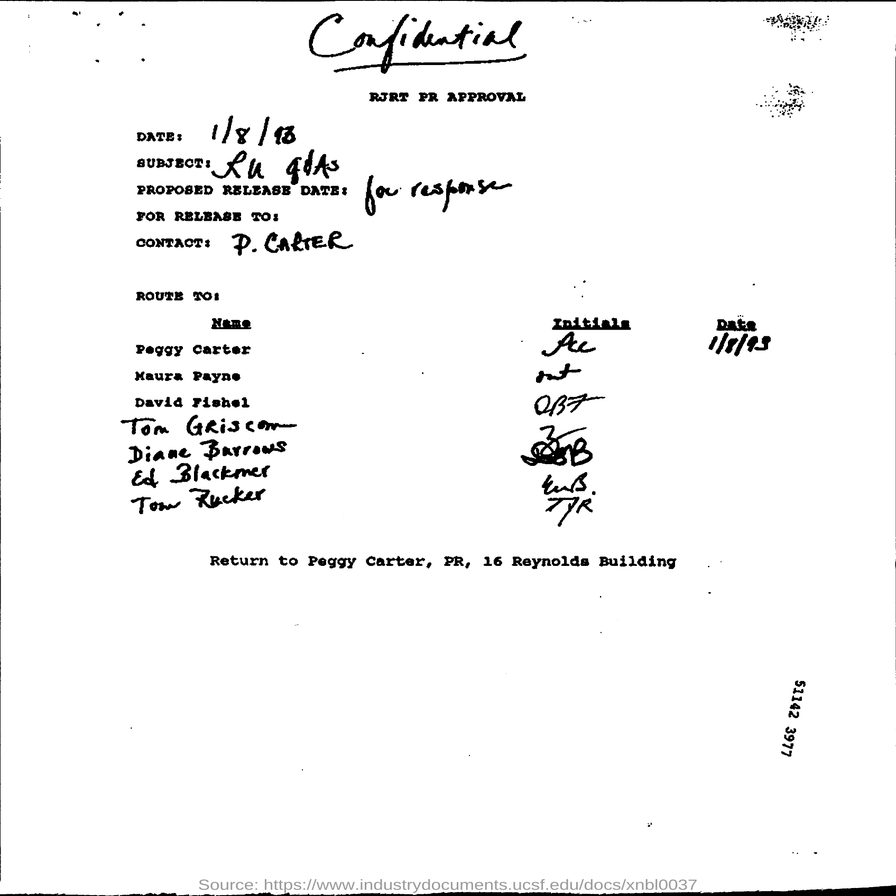

In [19]:
ds[0]['image'].resize((896,896),resample=Image.Resampling.LANCZOS).convert("RGB")

In [24]:
prompt = ds[0]['question']
image = ds[0]['image'].resize((896,896),resample=Image.Resampling.LANCZOS).convert("RGB")
model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

In [27]:
with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    pred = processor.decode(generation, skip_special_tokens=True)

In [28]:
pred

'1/8/93'

In [29]:
score, closest_gt = anls_score(ds[0]['answer'], pred, return_gt=True)
score

/home/dgj335/.local/lib/python3.10/site-packages/anls_star/anls_star.py:513: UserWarning: Treating ground truth as a list of options. This is a compatibility mode for ST-VQA-like datasets.
  warnings.warn(


1.0